**420-A52-SF - Algorithmes d'apprentissage supervisé - Automne 2022 - Spécialisation technique en Intelligence Artificielle**<br/>
MIT License - Copyright (c) 2022 Mikaël Swawola
<br/>
![Travaux Pratiques - Évaluation des modèles de classification](static/13-A1-banner.png)
<br/>
**Objectif:** cette séance de travaux pratiques a pour objectif la mise en oeuvre des différentes techniques d'évaluation des modèles de classifications sur des données débalancées

In [55]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [25]:
import sys
!{sys.executable} -m pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable


### 1 - Simulation de données

In [56]:
from sklearn.datasets import make_moons
from imblearn.datasets import make_imbalance

import pandas as pd
import numpy as np
#from sklearn.datasets import 

In [57]:
N = 10000
ratio_debalancement = 0.01

X_raw, y_raw = make_moons(n_samples=10*N, shuffle=True, noise=0.3, random_state=2020)
X, y =  make_imbalance(X_raw, y_raw, sampling_strategy={0: int(N*(1-ratio_debalancement)), 1: int(N*(ratio_debalancement))})

#### Affichage du jeu de données simulé (classes balancées)

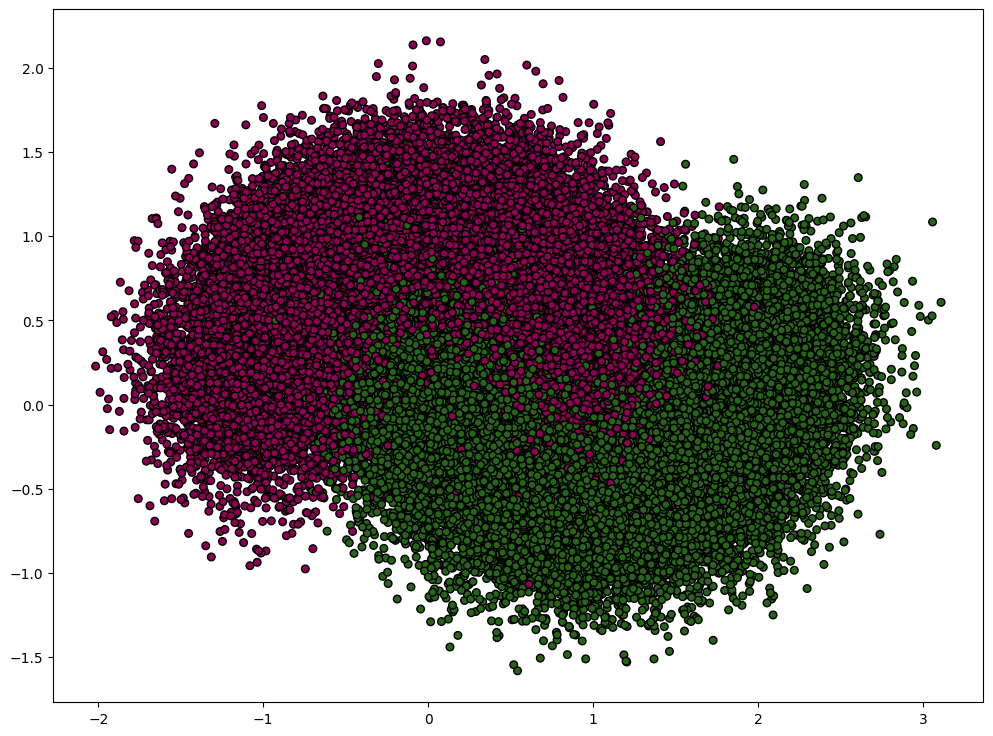

In [58]:
import matplotlib.pyplot as plt

fig = plt.figure(1, figsize=(12, 9))
plt.scatter(X_raw[:, 0], X_raw[:, 1], c=y_raw, cmap='PiYG', edgecolor='k', s=30)
plt.show()

#### Affichage du jeu de données simulé (classes fortement débalancées)

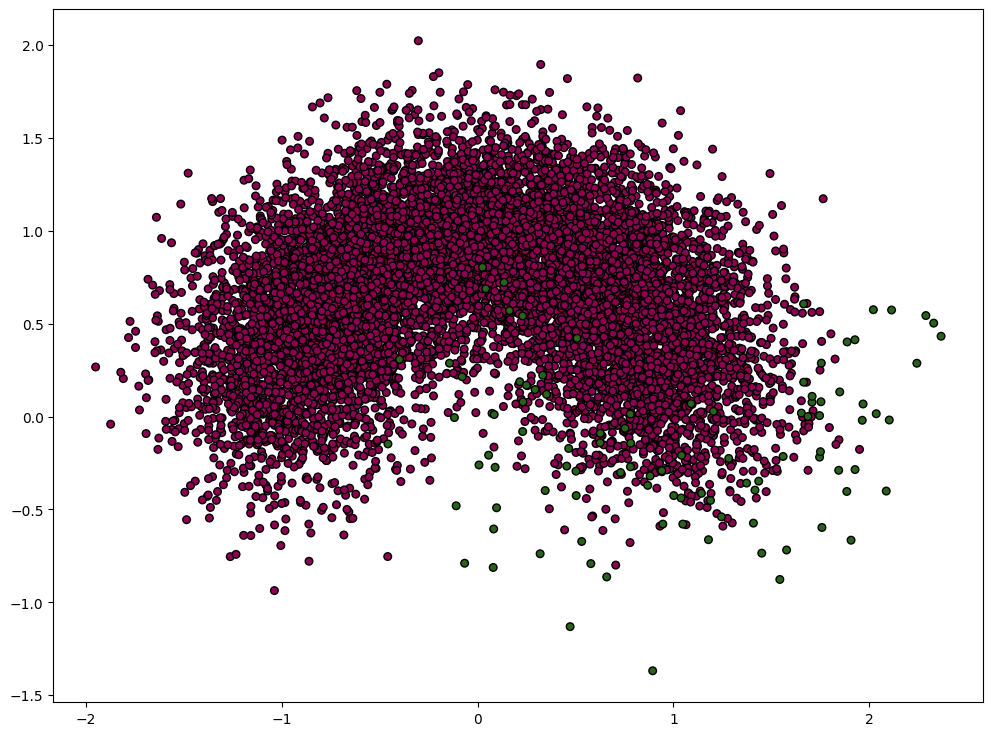

In [59]:
fig = plt.figure(1, figsize=(12, 9))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='PiYG', edgecolor='k', s=30)
plt.show()

### 2 - Préparation de données

<strong>
Séparation des données en train (40%), validation (30%) et test (30%)
</strong>

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=3/7, random_state=2020)

### 3 - Modèle de référence (baseline)

#### Création d'un modèle baseline et calcul de sa précision (accuracy)

In [61]:
from sklearn.dummy import DummyClassifier
baseline_clf = DummyClassifier(strategy = 'most_frequent')
baseline_clf.fit(X_train, y_train)
baseline_clf.score(X_train, y_train)

0.9905495274763738

### 4 - Entraînement d'un classificateur (régression logistique, ordre 3)

#### Entraînement du modèle et choix du paramètre de régularisation

In [34]:
from sklearn.preprocessing import StandardScaler
### retroune un dataframe standardisé 
def get_scaled_df(pDf, pScaler = StandardScaler()):
    #std = StandardScaler()    
    #return pd.DataFrame(pScaler.fit_transform(pDf), columns = pDf.columns)
    return pd.DataFrame(pScaler.fit_transform(pDf))

In [31]:
### affiche les metriques
def print_metrics(pYtest, pYpred, nbDecimal=3 ):
    print('Mean Absolute Error - [MAE]:', round(metrics.mean_absolute_error(pYtest, pYpred), nbDecimal) )  
    print('Mean Squared Error - [MSE]:', round(metrics.mean_squared_error(pYtest, pYpred),nbDecimal ) )  
    print('Root Mean Squared Error - [RMSE]:', round(np.sqrt(metrics.mean_squared_error(pYtest, pYpred)),nbDecimal) )
    

In [35]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression


# ## regression logistique - https://www.kaggle.com/code/satishgunjal/multiclass-logistic-regression-using-sklearn/notebook
def analyze_logistic(pDfX, pDfY, pCv=5, pMaxIter=1000, pScaler=StandardScaler()):
    X_train, X_test, y_train, y_test = train_test_split(get_scaled_df(pDfX)
                                                        ,pDfY
                                                        , shuffle=True
                                                        , test_size=0.20
                                                        , random_state=2020)
    ## ovr = one versus rest
    lm = LogisticRegressionCV(multi_class = 'ovr', fit_intercept=True, cv=pCv, max_iter=pMaxIter)
    lm.fit(get_scaled_df(X_train), y_train)

    y_pred = lm.predict(X_test)
    print(y_pred)

    print_metrics(y_test, y_pred)
    
    print ("Train - Accuracy [score]: ", lm.score(X_train, y_train))
    print ("Test - Accuracy [score]: ", lm.score(X_test, y_test))
    

In [36]:
analyze_logistic(X_raw, y_raw)

[1 1 1 ... 1 1 1]


NameError: name 'metrics' is not defined

In [67]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

model = LogisticRegression()
model.fit(X_train_poly, y_train)

accuracy = model.score(X_val_poly, y_val)
accuracy_test = model.score(X_test_poly, y_test)

print("accuracy: ", accuracy)
print("accuracy_test: ", accuracy_test)

#print(model.score(X_train, y_train))
#print(model.score(X_test, y_test))

#logreg=None

accuracy:  0.9927671488567429
accuracy_test:  0.9923333333333333


In [64]:
X_train_poly.shape

(5714, 10)

#### Affichage de la frontière de décision

([], [])

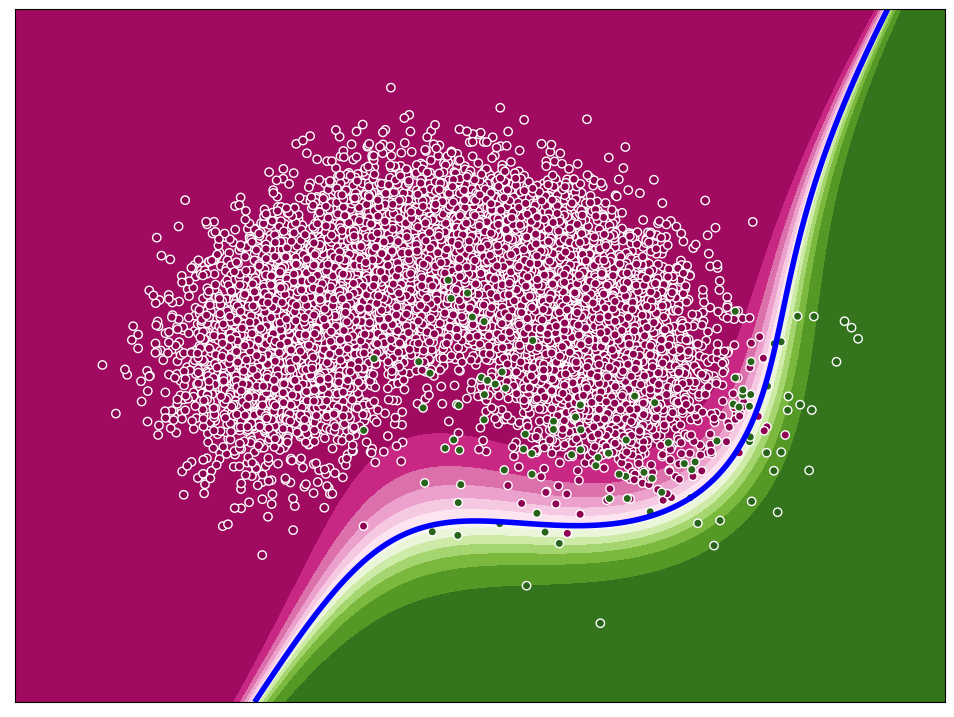

In [68]:
import numpy as np

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .01  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

CC = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict_proba(poly.fit_transform(CC))[:,1].reshape(xx.shape)

fig = plt.figure(2, figsize=(12, 9))

plt.contourf(xx, yy, Z, cmap="PiYG", levels=15)
plt.contour(xx, yy, Z, [0.5], colors=["b"], linewidths=[4])

plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='w', cmap='PiYG', linewidth=1)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

### 5 - Matrice de confusion sur l'ensemble de validation

#### Affichage de la matrice de confusion pour un seuil de classification rigide de 0.5. Utiliser le fichiers helpers.py

Confusion matrix, without normalization
[[2969    2]
 [  21    8]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2971
           1       0.80      0.28      0.41        29

    accuracy                           0.99      3000
   macro avg       0.90      0.64      0.70      3000
weighted avg       0.99      0.99      0.99      3000

0.9923333333333333


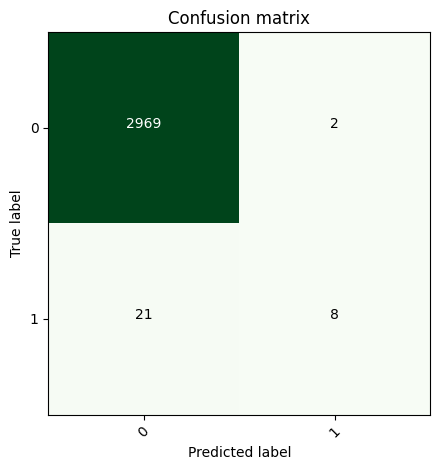

In [94]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from helpers import plot_confusion_matrix as hlp

y_pred = model.predict(X_test_poly)
matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(matrix, classes=(0,1), normalize=False, cmap=plt.cm.Greens)
print(matrix)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

#### Calcul de la précision sur l'ensemble de validation

### 6 - Courbe ROC et l'AUC

#### Calcul de la précision sur l'ensemble de validation

#### Sélection de la meilleur valeur du seuil

#### Affichage de la frontière de décision

In [ ]:
fig = plt.figure(5, figsize=(12, 9))

plt.contourf(xx, yy, Z, cmap="PiYG", levels=15)
plt.contour(xx, yy, Z, [selected_threshold], colors=["b"], linewidths=[4])

plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, edgecolors='w', cmap='PiYG', linewidth=1)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

### 7 -  Calculer la courbe de précision/rappel

#### Affichage de la courbe de précision et rappel

### 8 - Évaluer le F-score pour différents seuils

#### Sélection d'une valeur de beta et calcul du F-score pour différentes valeurs du seuil

### 9 - Calcul de la métrique d'entropie croisée

#### Calcul de l'entropie croiseé (ou log loss)

### 10 - Calcul de la métrique d'utilité

#### Calcul de la matrice d'utilité correspondant à la matrice de confusion précédente et avec les coûts suivants

FP: -100
FN: -10000
TP: 1000
TN: 0

### Fin de l'atelier